In [23]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import load_data
from Project_Models import RNN_Model, LSTM_Model
import torch
import torch.nn as nn

print("current device:", torch.cuda.get_device_name(torch.cuda.current_device()))

def normalize(x):
    """ normalize data of each column """
    maxtensor = x.max(0, keepdim=True)[0]
    maxtensor[maxtensor==0] = 1e-4
    x_normed = x / maxtensor
    return x_normed, maxtensor

def standardize(x):
    mean = x.mean(0, keepdim=True)[0]
    mean[mean==0] = 1e-4
    std  = x.std(0, keepdim=True)[0]
    std[std==0] = 1e-4
    x_normed = (x - mean) / std
    return x_normed, mean, std

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = load_data.load_county_level('./data/covid19-severity-prediction/data').head(1620).sample(frac=1, random_state=1)

def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()

def to_torch(x, device='cpu'):
    return torch.tensor(x).unsqueeze(-1).to(device).float()

FEATURES = [
    '#Hospitals', 
    '#ICU_beds', 
    'MedicareEnrollment,AgedTot2017', 
    'DiabetesPercentage', 
    'HeartDiseaseMortality',
    'StrokeMortality',
    'Smokers_Percentage',
    'RespMortalityRate2014',
    '#FTEHospitalTotal2017',
    "TotalM.D.'s,TotNon-FedandFed2017",
    '#HospParticipatinginNetwork2017']

current device: GeForce RTX 3080
loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [3]:
# Preprocess Data

maxload = 1600 #

x = form_input_tensor(df, FEATURES,
    maxload=maxload).to(device)
for i in range(x.shape[1] - 1, 0, -1):
    x[:,i,-2] -= x[:,i-1,-2]
    x[:,i,-1] -= x[:,i-1,-1]

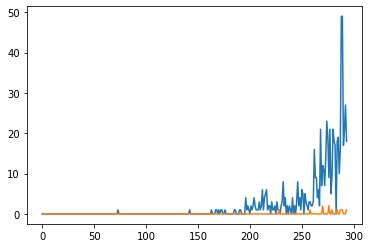

In [4]:
k=x[0][:,-2:]
kcase=k[:,0]
kd = k[:,1]
plt.plot(range(294), to_numpy(kcase))
plt.plot(range(294), to_numpy(kd))
plt.show()

In [5]:
x, xmean, xstd = standardize(x)
# x[torch.isnan(x)] = 0
print(f"#x nan: {(torch.sum(torch.isnan(x)))}")
# print("x:", x)

# y = form_labels_tensor(df, maxload=maxload).to(device)

# for i in range(y.shape[1] - 1, 0, -1):
#     y[:,i,-2] -= y[:,i-1,-2]
#     y[:,i,-1] -= y[:,i-1,-1]

# y, ymean, ystd = standardize(y)
# print(f"#y nan: {torch.sum(torch.isnan(y))}")
# print("y:", y * ymaxtensor)

Xtrain = x[:-50]
# Ytrain = y[:-50]
Xtest  = x[90:]
# Ytest  = y[90:]

#x nan: 0


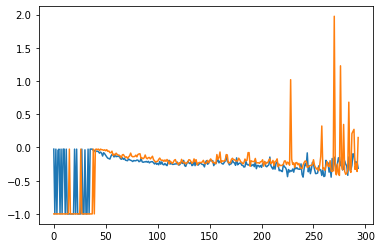

In [6]:
k=x[0][:,-2:]
kcase=k[:,0]
kd = k[:,1]
plt.plot(range(294), to_numpy(kcase))
plt.plot(range(294), to_numpy(kd))
plt.show()

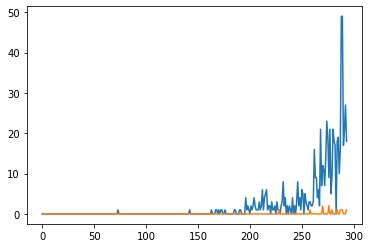

In [7]:
k=k*xstd[:,-2:]+xmean[:,-2:]
kcase=k[:,0]
kd = k[:,1]
plt.plot(range(294), to_numpy(kcase))
plt.plot(range(294), to_numpy(kd))
plt.show()

In [8]:
from Project_Models.LSTM_Model import LSTM
from Project_Models.RNN_Model import RNN

In [9]:
def trainModel(model, batchsize, lr, epochs):
    print("training data shape:", Xtrain.shape)
    # criterion = lambda y, yhat: torch.sqrt(nn.MSELoss()(y, yhat))
    criterion = nn.MSELoss()
    # criterion = nn.SmoothL1Loss()
    learning_rate = lr
    num_epoches = epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    trange = tqdm.trange(num_epoches)
    for epoch in trange:
        for start in range(0, Xtrain.shape[0], batchsize):
            batch_start = start
            batch_end = min(start + batchsize, Xtrain.shape[0])
            for i in range(1, Xtrain.shape[1]):
                yhat = model(Xtrain[batch_start:batch_end,:i,:])
                loss = criterion(yhat, Xtrain[batch_start:batch_end,i,-2:])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # scheduler.step(loss.item())
                trange.set_description(f'Epoch [{epoch + 1}/{num_epoches}], Batch [{int(start/batchsize)}/{int(Xtrain.shape[0]/batchsize)}] Loss: {loss.item():.4f}')
                trange.refresh()
    return model

In [20]:
def evaluate(model, rangelist, plot=False):
    msecases =[]
    msedeaths=[]
    for i in tqdm.tqdm(rangelist):
        county_name = df.iloc[i]['CountyName']
        state_name = df.iloc[i]['StateName']
        msecasei, msedeathi = plotPrediction(model, county_name, state_name, plot=plot)
        msecases.append(msecasei)
        msedeaths.append(msedeathi)
    return [msecases, msedeaths]

## Vanilla LSTM

In [11]:
lstm = LSTM(input_size=Xtrain.shape[2], hidden_size=128, num_layers=3).to(device)

In [14]:
trainModel(lstm, batchsize=100, lr=1e-3, epochs=18)

Epoch [17/18], Batch [9/15] Loss: 0.2147:  89%|████████▉ | 16/18 [49:38<06:12, 186.15s/it]


KeyboardInterrupt: 

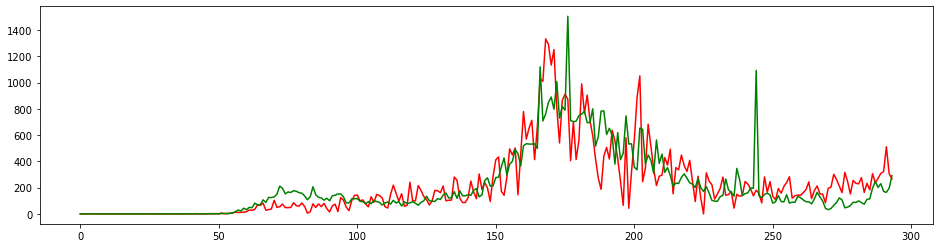

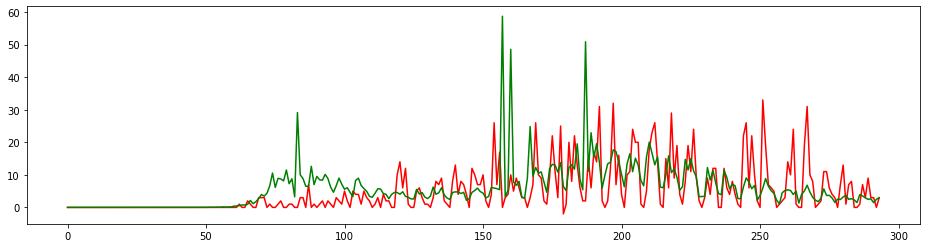

(22783.93537414966, 63.89764030612245)

In [17]:
plotPrediction(lstm, 'Orange', 'CA')

In [24]:
testcasesmse, testdeathsmse = evaluate(lstm, range(1550, 1610))

100%|██████████| 60/60 [01:34<00:00,  1.58s/it]


In [25]:
np.mean(testcasesmse), np.mean(testdeathsmse)

(813.6778922913566, 6.409397886994203)

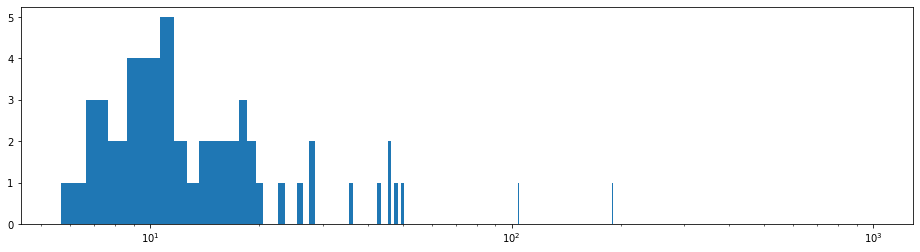

In [213]:
plt.figure(figsize=(16,4))
plt.gca().set_xscale('log')
plt.hist(testcasesmse, bins=1000)
plt.show()

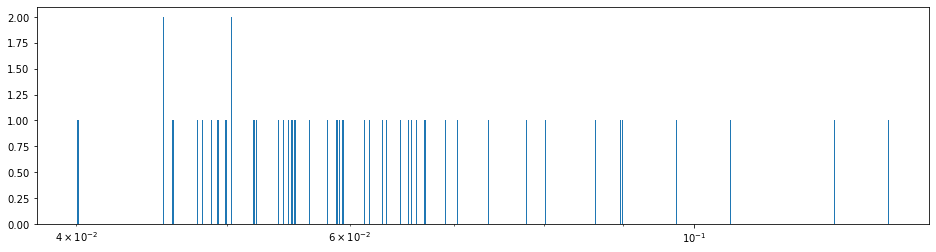

In [215]:
plt.figure(figsize=(16,4))
plt.gca().set_xscale('log')
plt.hist(testdeathsmse, bins=1000)
plt.show()

In [ ]:
plotPrediction(rnn, "Clinch", "GA")

In [182]:
trainModel(rnn, 1e-6, 100)

Epoch [100/100], Loss: 0.5761: 100%|██████████| 100/100 [16:00<00:00,  9.61s/it]


RNN(
  (rnn): RNN(13, 128, num_layers=3, batch_first=True)
  (casefc1): Linear(in_features=128, out_features=64, bias=True)
  (casefc2): Linear(in_features=64, out_features=32, bias=True)
  (casefc4): Linear(in_features=32, out_features=32, bias=True)
  (casefc5): Linear(in_features=32, out_features=32, bias=True)
  (casefc3): Linear(in_features=32, out_features=1, bias=True)
  (deathfc1): Linear(in_features=128, out_features=64, bias=True)
  (deathfc2): Linear(in_features=64, out_features=32, bias=True)
  (deathfc3): Linear(in_features=32, out_features=1, bias=True)
  (activation): ReLU()
)

In [13]:
lstm = LSTM(input_size=Xtrain.shape[2], hidden_size=128, num_layers=3).to(device)

In [14]:
Xtrain.shape, Xtest.shape

(torch.Size([1550, 294, 13]), torch.Size([1510, 294, 13]))

In [16]:
def plotPrediction(model, countyname, statename, plot=True):
    orange = df[(df['StateName'] == statename) & (df['CountyName'] == countyname)]
    x = form_input_tensor(orange, FEATURES, maxload=maxload).to(device)
    truey = x[:, :, -2:]
    for i in range(x.shape[1] - 1, 0, -1):
        x[:,i,-2] -= x[:,i-1,-2]
        x[:,i,-1] -= x[:,i-1,-1]
    xnorm = (x - xmean) / xstd
    x[torch.isnan(x)]=0
    # check if there is nan in x
    # print(f"#x nan: {(torch.sum(torch.isnan(x)))}")

    # print(f"x.shape: {x.shape}")
    # print("x:", x * )
    # y = form_labels_tensor(df, maxload=maxload).to(device)
    # ynorm = (y - ymean) / ystd
    # print(f"#y nan: {torch.sum(torch.isnan(y))}")

    yhat = torch.zeros((x.shape[1], 2), dtype=torch.float32, device='cuda')
    for i in range(1, x.shape[1]):
        yhati = None
        with torch.no_grad():
            xi = xnorm[:,:i,:]
            # print(xi.shape)
            yhati = model(xi)
        # print(yhati.shape)
        # yhati = yhati
        # print(yhati.shape)
        yhat[i] = (yhati)
    # print(yhat)
    yhat = yhat*xstd[:,-2:]+xmean[:,-2:]
    yhat[yhat<0]=0

    truey = to_numpy(truey)
    yhat = to_numpy(yhat)
    if plot:
        plt.figure(figsize=(16,4))
        # plt.ylim((0, 70000))
        plt.plot(range(len(truey)),truey[:,0],'r-')
        plt.plot(range(len(truey)),yhat[:,0],'g-')
        # plt.plot(range(len(truey)), np.absolute(truey[:,0]-yhat[:,0]), 'b-')
        
        plt.show()
        plt.figure(figsize=(16,4))
        plt.plot(range(len(truey)),truey[:,1],'r-')
        plt.plot(range(len(truey)),yhat[:,1],'g-')
        # plt.plot(range(len(truey)), np.absolute(truey[:,1]-yhat[:,1]), 'b-')
        plt.show()
    msecases = (np.sum((truey[:,0] - yhat[:,0]) ** 2) / len(truey))
    msedeaths= (np.sum((truey[:,1] - yhat[:,1]) ** 2) / len(truey))
    return msecases, msedeaths